# Initializations and Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
! pip install nibabel
import nibabel as nib
import numpy as np
import os, glob
import psutil
import gc
import pandas as pd
import seaborn as sns
import zipfile
import os, glob, csv
from scipy.ndimage import binary_fill_holes, binary_opening, binary_closing
from io import BytesIO


mpl.rcParams.update({
    "font.family": "Liberation Sans",   # or "Liberation Sans"
    "pdf.fonttype": 42,             # Embed TrueType fonts
    "ps.fonttype": 42,              # Prevent outline fonts
    "text.usetex": False,
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "savefig.dpi": 300
})

In [2]:
# changes directory from colab to gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Choose your base folder (local runtime or Drive)
BASE_DIR = "/content/drive/MyDrive/Capstone-Project/figures"

# Create it if it doesn't exist
os.makedirs(BASE_DIR, exist_ok=True)

print(f"Figures will be saved to: {BASE_DIR}")

Figures will be saved to: /content/drive/MyDrive/Capstone-Project/figures


# Tissue segmentation- using 3-class GMM

In [4]:
# ---------- utils ----------
def list_files(roots, patterns):
    out = []
    for r in roots:
        for pat in patterns:
            out += glob.glob(os.path.join(r, pat), recursive=True)
    return sorted(set(out))

def voxel_volume_mm3(aff):
    return abs(np.linalg.det(aff[:3,:3]))

def inbrain_mask(arr, p=5):
    finite = np.isfinite(arr)
    if not np.any(finite): return np.zeros_like(arr, bool)
    thr = np.percentile(arr[finite], p)
    m = finite & (arr > thr)
    m = binary_fill_holes(m)
    m = binary_opening(m)
    m = binary_closing(m)
    return m

# ---------- tiny GMM (1D EM, K=3) ----------
def gmm_fit_1d_em(x, K=3, max_iter=100, tol=1e-5, seed=0):
    """
    x: 1D np.ndarray of intensities (float)
    returns (pi, mu, var) and responsibilities R (N,K)
    """
    rng = np.random.default_rng(seed)
    x = x.astype(np.float64)
    N = x.size
    # init by quantiles
    qs = np.percentile(x, np.linspace(5, 95, K))
    mu = qs.copy()
    var = np.full(K, np.var(x) * 0.25 + 1e-6)
    pi = np.full(K, 1.0 / K)

    prev_ll = -np.inf
    for _ in range(max_iter):
        # E-step: responsibilities
        # N(x|mu,var)
        den = np.zeros((N, K), dtype=np.float64)
        for k in range(K):
            v = var[k] + 1e-12
            den[:, k] = pi[k] * np.exp(-0.5 * (x - mu[k])**2 / v) / np.sqrt(2*np.pi*v)
        s = den.sum(axis=1, keepdims=True) + 1e-12
        R = den / s

        # M-step
        Nk = R.sum(axis=0) + 1e-12
        pi = Nk / N
        mu = (R * x[:, None]).sum(axis=0) / Nk
        var = (R * (x[:, None] - mu[None, :])**2).sum(axis=0) / Nk
        var = np.maximum(var, 1e-6)

        # log-likelihood
        ll = np.sum(np.log(s))
        if ll - prev_ll < tol:
            break
        prev_ll = ll
    return pi, mu, var, R

# ---------- main segmentation ----------
def segment_t1_to_tissues(t1_path, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    img = nib.load(t1_path)
    arr = img.get_fdata(dtype=np.float32)

    # in-brain mask
    m = inbrain_mask(arr, p=5)
    if not m.any():
        # write empty outputs for consistency
        stem = os.path.basename(t1_path).replace(".nii.gz","").replace(".nii","")
        label_out = os.path.join(out_dir, f"{stem}_seg_labels.nii.gz")
        post_outs = [os.path.join(out_dir, f"{stem}_post_{name}.nii.gz") for name in ["csf","gm","wm"]]
        lbl = np.zeros_like(arr, dtype=np.uint8)
        nib.save(nib.Nifti1Image(lbl, img.affine, img.header), label_out)
        for p in post_outs:
            nib.save(nib.Nifti1Image(np.zeros_like(arr, dtype=np.float32), img.affine, img.header), p)
        return {"file": t1_path, "CSF_mm3": 0.0, "GM_mm3": 0.0, "WM_mm3": 0.0}

    x = arr[m].astype(np.float64)

    # Robust intensity clipping to reduce tails
    lo, hi = np.percentile(x, [0.5, 99.5])
    x = np.clip(x, lo, hi)

    # Fit 3-class GMM
    pi, mu, var, R = gmm_fit_1d_em(x, K=3, max_iter=100, tol=1e-5, seed=0)

    # Map classes by mean intensity: CSF (low), GM (mid), WM (high)
    order = np.argsort(mu)  # ascending
    cls_names = ["CSF", "GM", "WM"]
    # full-volume posteriors
    post_full = np.zeros((arr.size, 3), dtype=np.float32)
    # recompute softmax-like responsibilities for all voxels (inside mask only) using learned params
    def posteriors_all(v):
        # returns (N,3)
        den = []
        for k in range(3):
            vark = var[order[k]] + 1e-12
            muk = mu[order[k]]
            pik = pi[order[k]]
            den.append(pik * np.exp(-0.5 * (v - muk)**2 / vark) / np.sqrt(2*np.pi*vark))
        den = np.stack(den, axis=1)
        s = den.sum(axis=1, keepdims=True) + 1e-12
        return den / s

    v_in = arr[m].astype(np.float64)
    post_m = posteriors_all(v_in)  # (N_in, 3) -> columns [CSF, GM, WM] in intensity order
    post_full[m.reshape(-1), :] = post_m
    post_full = post_full.reshape(arr.shape + (3,))

    # Hard labels: argmax over posteriors (0 background)
    hard = np.zeros_like(arr, dtype=np.uint8)
    hard[m] = (np.argmax(post_m, axis=1) + 1).astype(np.uint8)  # 1..3

    # Volumes
    vv = voxel_volume_mm3(img.affine)
    vols = {}
    for k, name in enumerate(cls_names, start=1):
        vols[f"{name}_mm3"] = float((hard == k).sum() * vv)

    # Save outputs
    stem = os.path.basename(t1_path).replace(".nii.gz","").replace(".nii","")
    label_out = os.path.join(out_dir, f"{stem}_seg_labels.nii.gz")
    nib.save(nib.Nifti1Image(hard.astype(np.uint8), img.affine, img.header), label_out)

    post_names = ["csf","gm","wm"]
    for i, name in enumerate(post_names):
        pmap = post_full[..., i]
        nib.save(nib.Nifti1Image(pmap.astype(np.float32), img.affine, img.header),
                 os.path.join(out_dir, f"{stem}_post_{name}.nii.gz"))

    res = {"file": t1_path}
    res.update(vols)
    return res


In [5]:
# ---------- batch over your preprocessed NFBS brains ----------
in_roots    = ["/content/drive/MyDrive/Capstone-Project/derivatives/pp_preproc_anat"]
in_patterns = ["**/*_preproc.nii.gz", "**/*_preproc.nii"]
t1_files = list_files(in_roots, in_patterns)
print("Found preprocessed brains:", len(t1_files))

seg_out_dir = "/content/drive/MyDrive/Capstone-Project/derivatives/pp_seg"
os.makedirs(seg_out_dir, exist_ok=True)

rows = []
for fp in t1_files:
    try:
        rows.append(segment_t1_to_tissues(fp, seg_out_dir))
    except Exception as e:
        print(f"[skip] {e.__class__.__name__}: {fp}")

# Save volumes CSV
df_tissue = pd.DataFrame(rows)
csv_path = os.path.join(seg_out_dir, "tissue_volumes.csv")
df_tissue.to_csv(csv_path, index=False)
print("Saved:", csv_path)

Found preprocessed brains: 124
Saved: /content/drive/MyDrive/Capstone-Project/derivatives/pp_seg/tissue_volumes.csv


# Visualize the 3 sub-groups and Validate that its GM-WM-CSF

## CHECK- Mean Tissue Volume in increasing order: GM > WM > CSF

In [6]:
# Basic stats
print(df_tissue.describe())


             CSF_mm3         GM_mm3         WM_mm3
count     124.000000     124.000000     124.000000
mean   264178.069851  669149.649924  342676.460861
std     86216.898775   91523.776377   58848.372199
min    106112.474495  492048.192772  233046.883621
25%    203852.029516  604018.086258  307064.791639
50%    262885.423878  655122.017159  332636.505131
75%    319354.822567  729140.425127  367511.795782
max    604429.045494  939949.764534  590517.425415


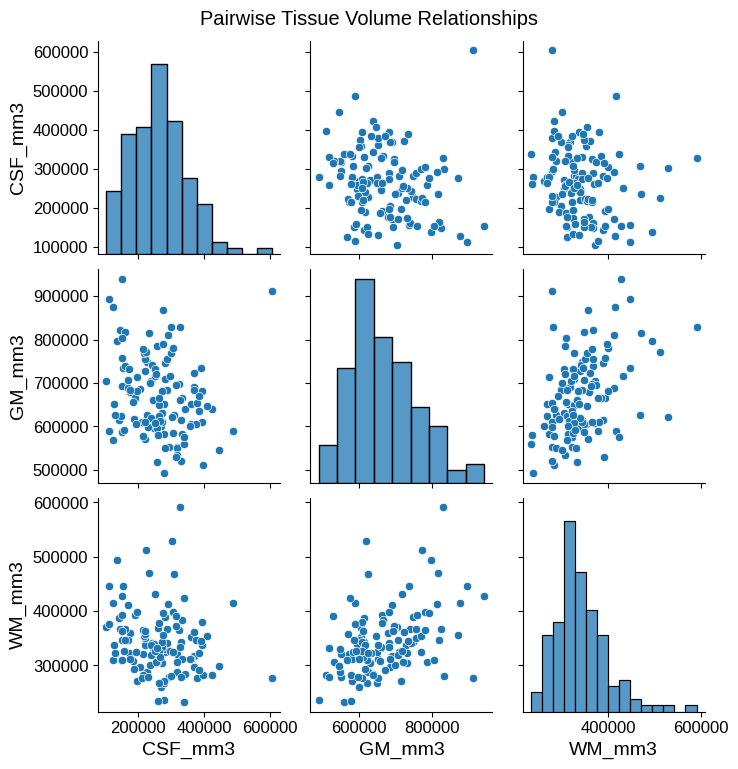

In [7]:
# Pairplot to see relationships
sns.pairplot(df_tissue[["CSF_mm3", "GM_mm3", "WM_mm3"]])
plt.suptitle("Pairwise Tissue Volume Relationships", y=1.02)
# save_path = os.path.join(BASE_DIR, "pairwise_vol_plot.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()


/tmp/ipython-input-2985865728.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_melt, x="Tissue", y="Volume_mm3", ci="sd", palette="pastel")
/tmp/ipython-input-2985865728.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_melt, x="Tissue", y="Volume_mm3", ci="sd", palette="pastel")


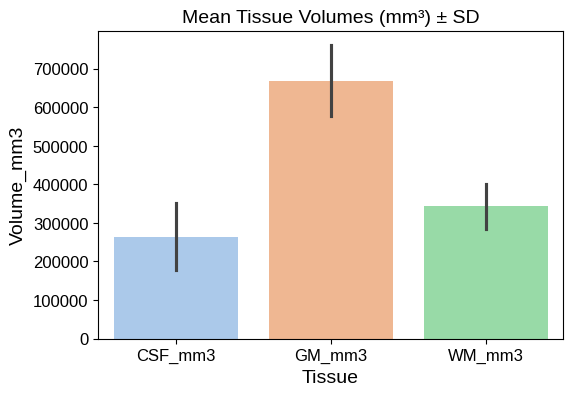

In [8]:
# Barplot of mean ± SD
df_melt = df_tissue.melt(value_vars=["CSF_mm3","GM_mm3","WM_mm3"], var_name="Tissue", value_name="Volume_mm3")
plt.figure(figsize=(6,4))
sns.barplot(data=df_melt, x="Tissue", y="Volume_mm3", ci="sd", palette="pastel")
plt.title("Mean Tissue Volumes (mm³) ± SD")
# save_path = os.path.join(BASE_DIR, "mean_tissue_vol.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()

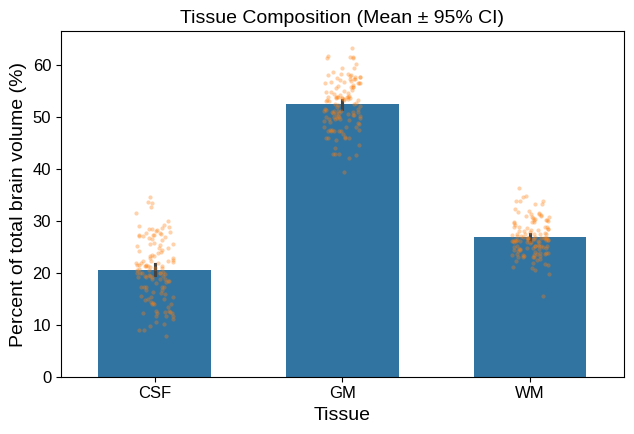

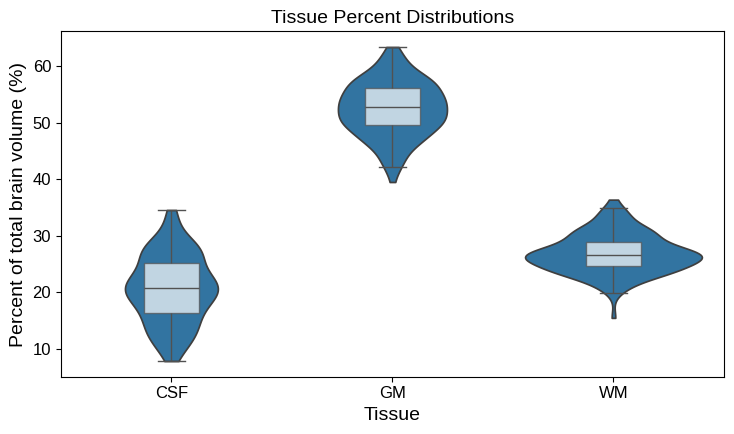

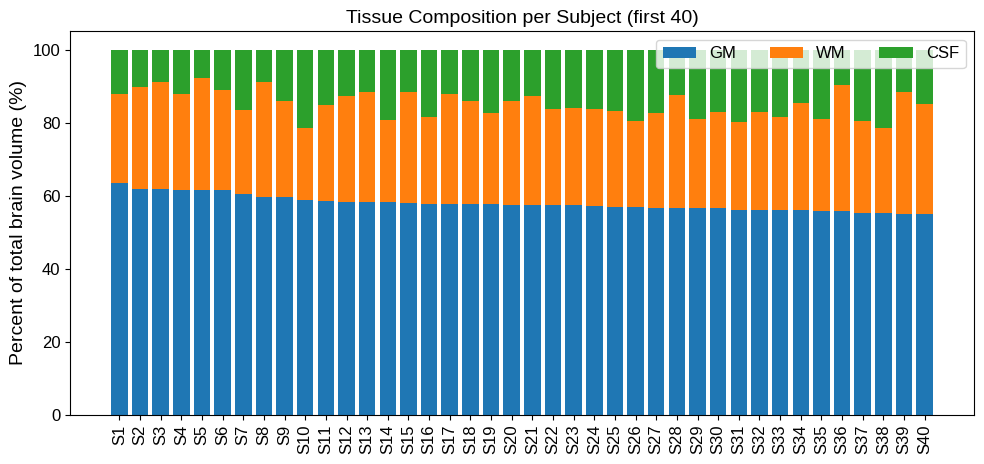

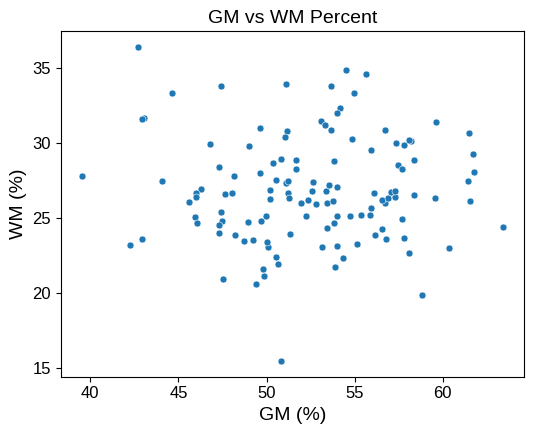

/tmp/ipython-input-1279095506.py:91: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


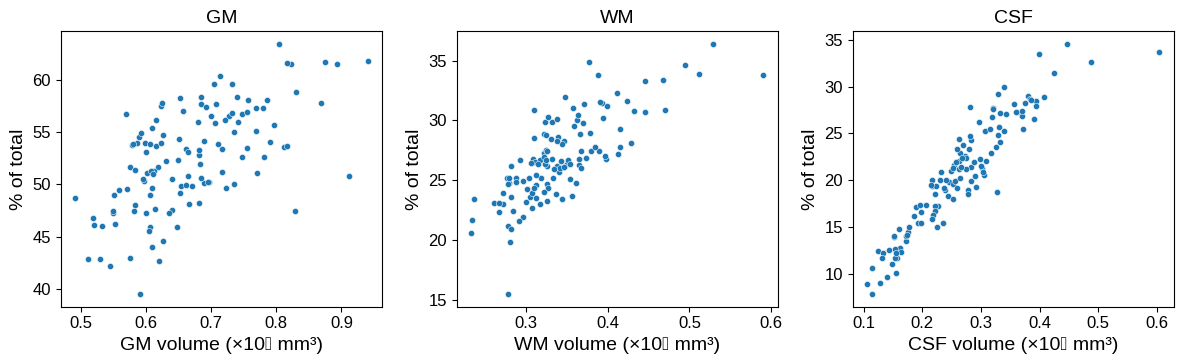

        count       mean       std        min         1%         5%  \
Tissue                                                                
CSF     124.0  20.640777  5.989946   7.844936   8.986043  11.170786   
GM      124.0  52.486032  4.817426  39.529250  42.340337  44.153251   
WM      124.0  26.873191  3.498127  15.485574  20.022826  21.755795   

              50%        95%        99%        max  
Tissue                                              
CSF     20.722255  29.215280  33.643107  34.568774  
GM      52.734642  60.227172  61.742193  63.413755  
WM      26.595042  33.357123  34.794415  36.403972  
[QC] Potential CSF outliers outside 1–99%: 4 observations
[QC] Potential GM outliers outside 1–99%: 4 observations
[QC] Potential WM outliers outside 1–99%: 4 observations


In [9]:
# ---------- compute fractions (percent) ----------
df = df_tissue.copy()
for col in ["CSF_mm3", "GM_mm3", "WM_mm3"]:
    if col not in df:
        raise ValueError(f"Missing column {col} in df_tissue")

df["Total_mm3"] = df[["CSF_mm3","GM_mm3","WM_mm3"]].sum(axis=1)
# filter out rows with zero/invalid totals
df = df[(df["Total_mm3"] > 0) & np.isfinite(df["Total_mm3"])].copy()

df["CSF_pct"] = 100.0 * df["CSF_mm3"] / df["Total_mm3"]
df["GM_pct"]  = 100.0 * df["GM_mm3"]  / df["Total_mm3"]
df["WM_pct"]  = 100.0 * df["WM_mm3"]  / df["Total_mm3"]

# Tidy for plotting
df_long = df.melt(
    value_vars=["CSF_pct","GM_pct","WM_pct"],
    var_name="Tissue", value_name="Percent"
)
df_long["Tissue"] = df_long["Tissue"].map({"CSF_pct":"CSF","GM_pct":"GM","WM_pct":"WM"})

# ---------- 1) Barplot of mean percentages with 95% CI ----------
plt.figure(figsize=(6.5, 4.5))
sns.barplot(
    data=df_long, x="Tissue", y="Percent",
    estimator=np.mean, errorbar=("ci", 95), width=0.6
)
sns.stripplot(
    data=df_long, x="Tissue", y="Percent", dodge=False, alpha=0.35, size=3
)
plt.ylabel("Percent of total brain volume (%)")
plt.title("Tissue Composition (Mean ± 95% CI)")
plt.tight_layout()
# save_path = os.path.join(BASE_DIR, "mean_tissue_vol.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()

# ---------- 2) Violin+box (distribution shape) ----------
plt.figure(figsize=(7.5, 4.5))
sns.violinplot(data=df_long, x="Tissue", y="Percent", inner=None, cut=0)
sns.boxplot(
    data=df_long, x="Tissue", y="Percent",
    showcaps=True, boxprops={"facecolor":"white","alpha":0.7},
    showfliers=False, width=0.25
)
plt.ylabel("Percent of total brain volume (%)")
plt.title("Tissue Percent Distributions")
plt.tight_layout()
# save_path = os.path.join(BASE_DIR, "tissue_perc_distr_violinplot.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()

# ---------- 3) Subject-level stacked bars (top N subjects for readability) ----------
# Sort by GM fraction (descending) to see pattern; show first N subjects
N = min(40, len(df))  # adjust if you want more/less
df_sorted = df.sort_values("GM_pct", ascending=False).head(N).reset_index(drop=True)
stack = np.vstack([df_sorted["GM_pct"], df_sorted["WM_pct"], df_sorted["CSF_pct"]])

plt.figure(figsize=(10, 4.8))
bottom = np.zeros(N)
labels = ["GM","WM","CSF"]
for i, lab in enumerate(labels):
    plt.bar(np.arange(N), stack[i], bottom=bottom, label=lab)
    bottom += stack[i]
plt.xticks(np.arange(N), [f"S{i+1}" for i in range(N)], rotation=90)
plt.ylabel("Percent of total brain volume (%)")
plt.title(f"Tissue Composition per Subject (first {N})")
plt.legend(ncol=3, frameon=True)
plt.tight_layout()
# save_path = os.path.join(BASE_DIR, "subject_level_stacked.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()

# ---------- 4) QC scatter: GM% vs WM% (should be negatively correlated) ----------
plt.figure(figsize=(5.5, 4.5))
sns.scatterplot(x=df["GM_pct"], y=df["WM_pct"], s=25)
plt.xlabel("GM (%)")
plt.ylabel("WM (%)")
plt.title("GM vs WM Percent")
plt.tight_layout()
plt.show()

# ---------- 5) Volumes vs Percents (spot scaling issues) ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 3.8), sharex=False, sharey=False)
pairs = [("GM_mm3","GM_pct"), ("WM_mm3","WM_pct"), ("CSF_mm3","CSF_pct")]
for ax, (vol, pct) in zip(axes, pairs):
    sns.scatterplot(ax=ax, x=df[vol]/1e6, y=df[pct], s=20)
    ax.set_xlabel(f"{vol.replace('_mm3','')} volume (×10⁶ mm³)")
    ax.set_ylabel("% of total")
    ax.set_title(vol.replace("_mm3","").upper())
plt.tight_layout()
# save_path = os.path.join(BASE_DIR, "perc_total_tissue.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()

# ---------- 6) Simple outlier flags (optional, prints only) ----------
summary = df_long.groupby("Tissue")["Percent"].describe(percentiles=[.01,.05,.95,.99])
print(summary)
for t in ["CSF","GM","WM"]:
    lo, hi = summary.loc[t, "1%"], summary.loc[t, "99%"]
    out_idx = df_long[(df_long["Tissue"]==t) & ~df_long["Percent"].between(lo, hi)].index
    if len(out_idx):
        print(f"[QC] Potential {t} outliers outside 1–99%: {len(out_idx)//1} observations")


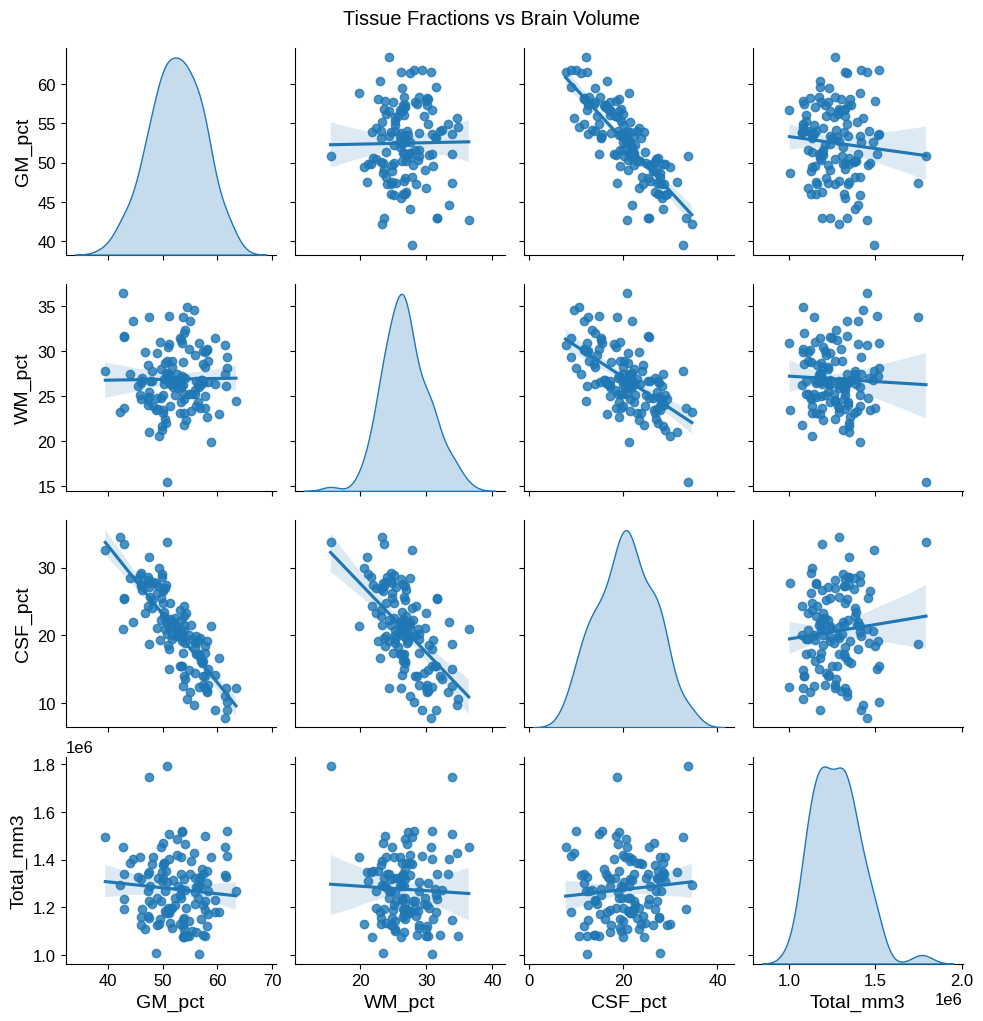

In [10]:
sns.pairplot(df, vars=["GM_pct","WM_pct","CSF_pct","Total_mm3"], kind="reg", diag_kind="kde")
plt.suptitle("Tissue Fractions vs Brain Volume", y=1.02)
# save_path = os.path.join(BASE_DIR, "tissue_frac_pairplot.pdf")
# plt.savefig(save_path, bbox_inches="tight")
plt.show()
